**This is the notebook for BeFR's model training.**
>In this notebook, we will use a Kaggle dataset to train a CNN model to classify real and deepfake images using a supervised learning process.

You can find all files for the full project here: https://github.com/ennovak/BeFR-Deepfake-Detection

# **1. Import Necessary Libraries**

In [1]:
# install dependencies
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.9 MB/s eta 0:00:00


In [2]:
# import libraries
import torch
import os
import random
import numpy as np
import joblib
import io

# database handling
import kagglehub
import pandas as pd
from torch.utils.data import DataLoader

# image processing
from PIL import Image, ImageFilter
import cv2

# visualization
import matplotlib.pyplot as plt

# model training
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Configure TensorFlow to use mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Checking/Setting Computation Device

Utilizing pyTorch support of GPU training of neural networks to speed up training process.

In [3]:
use_cuda = torch.cuda.is_available()

# Use this line below to enforce the use of the CPU (in case you don't have a supported GPU)
# use_cuda = False  # Uncomment this line to force CPU usage

device = torch.device("cuda:0" if use_cuda else "cpu")

print("Available device: {}".format(device))
print("If you see 'cuda:0', it means GPU is available and will be used")
print("If you see 'cpu', it means only CPU will be used")

Available device: cuda:0
If you see 'cuda:0', it means GPU is available and will be used
If you see 'cpu', it means only CPU will be used


# **2. Data Analysis and Preprocessing**

In [4]:
# import data

# Download latest version
path = kagglehub.dataset_download("ayushmandatta1/deepdetect-2025")

print("Path to dataset files:", path)

100%|██████████| 3.23G/3.23G [02:30<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1


In [5]:
# find train directory
train_dir = os.path.join(path, "ddata", "train")

# find test directory
test_dir = os.path.join(path, "ddata", "test")

In [6]:
# create datasets
train_filepaths = []
train_labels = []
for label in ['real', 'fake']:
  class_dir = os.path.join(train_dir, label)
  for filename in os.listdir(class_dir):
    train_filepaths.append(os.path.join(class_dir, filename))
    train_labels.append(label)
train_df = pd.DataFrame({"image_path": train_filepaths, "label": train_labels})

test_filepaths = []
test_labels = []
for label in ['real', 'fake']:
  class_dir = os.path.join(test_dir, label)
  for filename in os.listdir(class_dir):
    test_filepaths.append(os.path.join(class_dir, filename))
    test_labels.append(label)
test_df = pd.DataFrame({"image_path": test_filepaths, "label": test_labels})

Dataset Information:
Training data shape: (90409, 2)
Testing data shape: (21776, 2)
Labels: ['real' 'fake']

Training Image Distribution:
label
real    48815
fake    41594
Name: count, dtype: int64



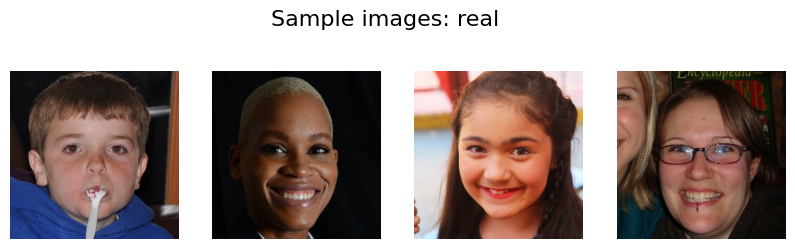

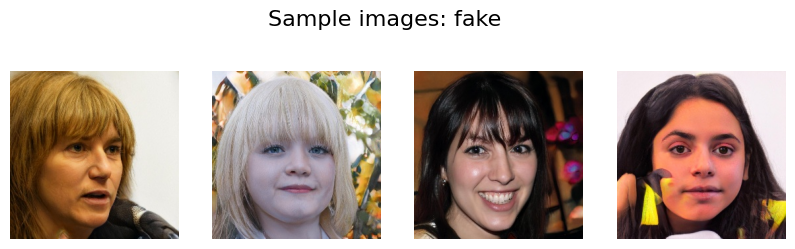

In [7]:
# display brief data information to confirm successful import
print("Dataset Information:")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Labels: {train_df['label'].unique()}")
print(f"\nTraining Image Distribution:")
print(train_df['label'].value_counts())
print() # add whitespace

# show some sample images
def display_sample_images(dataframe, category, num_samples=4):
    plt.figure(figsize=(10, 3))
    plt.suptitle(f"Sample images: {category}", fontsize=16)

    # Filter the dataframe for the specified category
    category_df = dataframe[dataframe["label"] == category]

    # Select random image paths from the filtered dataframe
    image_filepaths = random.sample(category_df["image_path"].tolist(), num_samples)


    for i, img_path in enumerate(image_filepaths):
        img = Image.open(img_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Show 4 random real images
display_sample_images(train_df, "real")

# Show 4 random deepfake images
display_sample_images(train_df, "fake")

In [8]:
train_df['label'] = train_df['label'].replace({'real': 0, 'fake': 1})
test_df['label'] = test_df['label'].replace({'real': 0, 'fake': 1})

# split the datasets into images and labels
X_train = train_df["image_path"]
y_train = train_df["label"]
X_test = test_df["image_path"]
y_test = test_df["label"]

# check shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (90409,)
X_test shape: (21776,)


/tmp/ipython-input-1377625777.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'] = train_df['label'].replace({'real': 0, 'fake': 1})
/tmp/ipython-input-1377625777.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label'] = test_df['label'].replace({'real': 0, 'fake': 1})


## Image Preprocessing

In [9]:
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify the image file
        return True
    except (IOError, Image.UnidentifiedImageError, SyntaxError) as e:
        # Catch various errors that indicate an invalid or corrupted image
        return False

print("Function 'is_valid_image' defined successfully.")

Function 'is_valid_image' defined successfully.


In [10]:
print("Validating training images...")
valid_train_filepaths = []
valid_train_labels = []
corrupted_train_count = 0
for i, image_path in enumerate(X_train):
    if is_valid_image(image_path):
        valid_train_filepaths.append(image_path)
        valid_train_labels.append(y_train.iloc[i])
    else:
        corrupted_train_count += 1

print(f"Found {corrupted_train_count} corrupted training images.")

print("Validating test images...")
valid_test_filepaths = []
valid_test_labels = []
corrupted_test_count = 0
for i, image_path in enumerate(X_test):
    if is_valid_image(image_path):
        valid_test_filepaths.append(image_path)
        valid_test_labels.append(y_test.iloc[i])
    else:
        corrupted_test_count += 1

print(f"Found {corrupted_test_count} corrupted test images.")

print("Image validation complete. Corrupted images filtered out.")

Validating training images...
Found 0 corrupted training images.
Validating test images...
Found 0 corrupted test images.
Image validation complete. Corrupted images filtered out.


In [11]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

def _decode_and_resize_image_pil(image_bytes):
    # Helper function to be wrapped by tf.py_function
    try:
        # Use BytesIO to open image from bytes
        img = Image.open(io.BytesIO(image_bytes.numpy()))
        # Ensure RGB format
        if img.mode != 'RGB':
            img = img.convert('RGB')
        # Resize using PIL
        img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.LANCZOS)
        return np.array(img)
    except (IOError, Image.UnidentifiedImageError, SyntaxError) as e:
        print(f"PIL decoding failed for an image: {e}")
        # Return a recognizable dummy array for filtering if PIL fails
        return np.full((IMG_WIDTH, IMG_HEIGHT, 3), -1, dtype=np.float32) # Use -1 to mark as corrupted

def preprocess_image(image_path, label):
    try:
        # Read the image file
        img_raw = tf.io.read_file(image_path)

        # Use tf.py_function to decode and resize with PIL
        # The output of py_function must be specified with Tout and shape_out
        img = tf.py_function(
            func=_decode_and_resize_image_pil,
            inp=[img_raw],
            Tout=tf.float32,
            name='pil_decode_and_resize'
        )
        # Ensure the shape is known after py_function
        img.set_shape([IMG_WIDTH, IMG_HEIGHT, 3])

        # Check if it's a dummy image from PIL failure
        # We'll consider any image where all pixels are -1 to be a dummy
        is_dummy = tf.reduce_all(tf.equal(img, -1.0))
        if is_dummy:
            dummy_image = tf.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=tf.float32)
            dummy_label = tf.constant(-1, dtype=tf.int64) # Mark this sample to be filtered out
            return dummy_image, dummy_label

        # Convert image to float32. EfficientNet's preprocess_input will handle normalization.
        img = tf.cast(img, tf.float32)
        return img, tf.cast(label, tf.int64) # Explicitly cast label to int64 to prevent dtype mismatch errors
    except Exception as e:
        print(f"Error in preprocess_image (TF side): {e}")
        # Fallback for any other unexpected TF errors during preprocessing
        dummy_image = tf.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=tf.float32)
        dummy_label = tf.constant(-1, dtype=tf.int64)
        return dummy_image, dummy_label

## Create datasets
> Here I am implementing Tensorflow's datasets for dynamic loading and preprocessing during model training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 256

# Create tf.data.Dataset for training data from valid images
train_ds = tf.data.Dataset.from_tensor_slices((valid_train_filepaths, valid_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.filter(lambda img, label: tf.not_equal(label, -1))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat() # Add .repeat() to ensure data is available for all epochs
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Create tf.data.Dataset for test data from valid images
test_ds = tf.data.Dataset.from_tensor_slices((valid_test_filepaths, valid_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.filter(lambda img, label: tf.not_equal(label, -1))
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("TensorFlow datasets for training and testing recreated with updated preprocessing.")
# Calculate and print actual dataset sizes for verification (this might be slow for large datasets)
# For repeated datasets, tf.data.experimental.cardinality returns UNKNOWN. So we print approximate numbers.
print(f"Approximate training dataset size: {len(valid_train_filepaths)} samples")
print(f"Approximate test dataset size: {len(valid_test_filepaths)} samples")

TensorFlow datasets for training and testing recreated with updated preprocessing.
Approximate training dataset size: 90409 samples
Approximate test dataset size: 21776 samples


Shape of images in the batch: (256, 128, 128, 3)
Labels in the batch: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


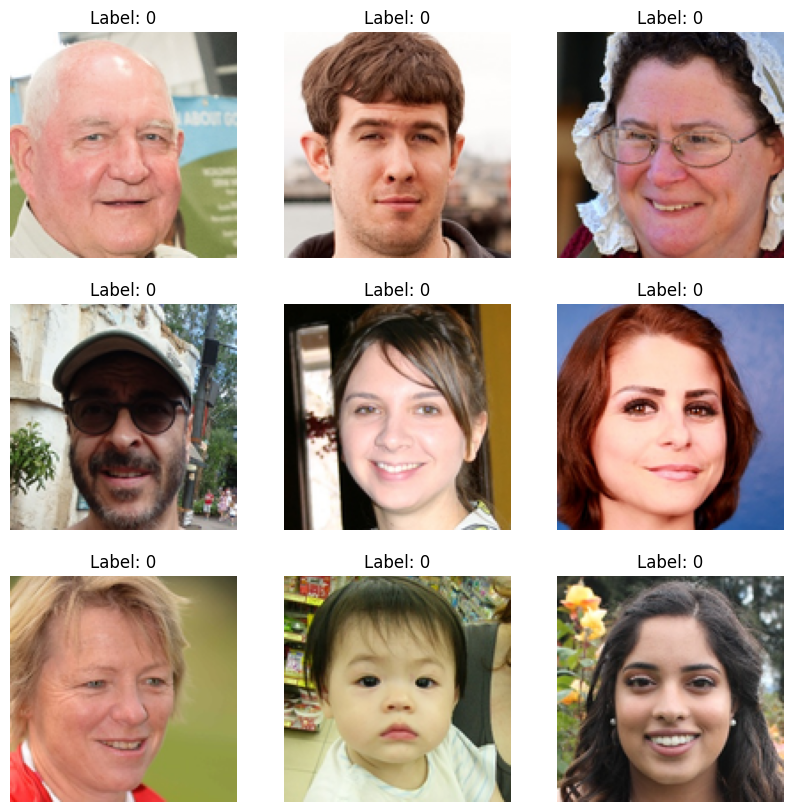

In [20]:
for images, labels in train_ds.take(1):
    print("Shape of images in the batch:", images.shape)
    print("Labels in the batch:", labels.numpy())

    plt.figure(figsize=(10, 10))
    # Select 9 random indices from the batch
    num_samples_to_display = min(9, images.shape[0])
    random_indices = random.sample(range(images.shape[0]), num_samples_to_display)

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(3, 3, i + 1)
        # Undo standardization for display by clipping values to [0,1] or original range
        # For display, we can scale values back to 0-1, as per_image_standardization makes mean=0, std=1
        # Displaying standardized images directly might show weird colors.
        # A common approach for visualization after standardization is to just clip/rescale for display.
        display_img = images[idx].numpy()
        display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
        plt.imshow(display_img)
        plt.title(f"Label: {labels[idx].numpy()}")
        plt.axis("off")
    plt.show()

# **3. Model Training**

In [14]:
# define model function, building off EfficientNet-b0
def create_model(hp):
    # Define the input shape for the images
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

    # Instantiate EfficientNetB0 as the base model
    base_model = EfficientNetB0(
        include_top=False, # Exclude the classification head
        weights='imagenet', # Load pre-trained ImageNet weights
        input_shape=input_shape
    )

    # Freeze the layers of the base_model
    base_model.trainable = False

    # Create a Sequential model for the classification head
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape), # Explicitly define input for the Sequential model
        # Preprocess input for EfficientNet
        tf.keras.layers.Lambda(preprocess_input), # Wrap preprocess_input in a Lambda layer
        # Data Augmentation Layers
        tf.keras.layers.RandomFlip("horizontal"), # Randomly flip images horizontally
        tf.keras.layers.RandomRotation(hp.Float('rotation_factor', min_value=0.05, max_value=0.2, step=0.05)), # Randomly rotate images
        tf.keras.layers.RandomZoom(hp.Float('zoom_factor', min_value=0.1, max_value=0.3, step=0.1)), # Randomly zoom in/out
        base_model, # Add the frozen base model
        tf.keras.layers.GlobalAveragePooling2D(), # Global average pooling layer
        # Add one or more Dense layers for classification
        tf.keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=64), activation='relu'),
        tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)), # Optional Dropout layer
        # Final Dense output layer for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32') # Use float32 for output layer in mixed precision
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [15]:
# Define the total size of the subset for hyperparameter tuning
total_subset_size_train = 1000  # Total images for train subset, will be split 50/50
total_subset_size_test = 1000    # Total images for test subset, will be split 50/50

# Calculate samples per class for balanced subsets
samples_per_class_train = total_subset_size_train // 2
samples_per_class_test = total_subset_size_test // 2

# --- Create balanced training subset from validated data ---
# Create a temporary DataFrame from the validated lists for easy sampling
validated_train_df = pd.DataFrame({"image_path": valid_train_filepaths, "label": valid_train_labels})

train_real_subset = validated_train_df[validated_train_df['label'] == 0].sample(n=samples_per_class_train, random_state=42)
train_fake_subset = validated_train_df[validated_train_df['label'] == 1].sample(n=samples_per_class_train, random_state=42)
balanced_train_df_subset = pd.concat([train_real_subset, train_fake_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_subset = balanced_train_df_subset["image_path"]
y_train_subset = balanced_train_df_subset["label"]

# --- Create balanced test subset from validated data ---
# Create a temporary DataFrame from the validated lists for easy sampling
validated_test_df = pd.DataFrame({"image_path": valid_test_filepaths, "label": valid_test_labels})

test_real_subset = validated_test_df[validated_test_df['label'] == 0].sample(n=samples_per_class_test, random_state=42)
test_fake_subset = validated_test_df[validated_test_df['label'] == 1].sample(n=samples_per_class_test, random_state=42)
balanced_test_df_subset = pd.concat([test_real_subset, test_fake_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

X_test_subset = balanced_test_df_subset["image_path"]
y_test_subset = balanced_test_df_subset["label"]

print(f"Created balanced training subset of size: {len(X_train_subset)} (Real: {y_train_subset.value_counts().get(0,0)}, Fake: {y_train_subset.value_counts().get(1,0)}) ")
print(f"Created balanced test subset of size: {len(X_test_subset)} (Real: {y_test_subset.value_counts().get(0,0)}, Fake: {y_test_subset.value_counts().get(1,0)})\n")


# --- Re-create TensorFlow Datasets with Subsets ---
AUTOTUNE = tf.data.AUTOTUNE
small_batch_size = 32

# Create tf.data.Dataset for training data from the valid image subsets
train_ds_subset = tf.data.Dataset.from_tensor_slices((X_train_subset, y_train_subset))
train_ds_subset = train_ds_subset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds_subset = train_ds_subset.filter(lambda img, label: tf.not_equal(label, -1)) # Keep for robustness if PIL misses something
train_ds_subset = train_ds_subset.shuffle(buffer_size=len(X_train_subset)) # Shuffle buffer size should be at least subset size
train_ds_subset = train_ds_subset.batch(small_batch_size)
train_ds_subset = train_ds_subset.prefetch(buffer_size=AUTOTUNE)

# Create tf.data.Dataset for test data from the valid image subsets
test_ds_subset = tf.data.Dataset.from_tensor_slices((X_test_subset, y_test_subset))
test_ds_subset = test_ds_subset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds_subset = test_ds_subset.filter(lambda img, label: tf.not_equal(label, -1)) # Keep for robustness if PIL misses something
test_ds_subset = test_ds_subset.batch(small_batch_size)
test_ds_subset = test_ds_subset.prefetch(buffer_size=AUTOTUNE)

print("TensorFlow debugging datasets created. You can now use `train_ds_debug` and `test_ds_debug` for tuning/training.")
print(f"New training debug dataset size: {tf.data.experimental.cardinality(train_ds_subset).numpy() * small_batch_size} samples (approx)")
print(f"New test debug dataset size: {tf.data.experimental.cardinality(test_ds_subset).numpy() * small_batch_size} samples (approx)")

Created balanced training subset of size: 1000 (Real: 500, Fake: 500) 
Created balanced test subset of size: 1000 (Real: 500, Fake: 500)

TensorFlow debugging datasets created. You can now use `train_ds_debug` and `test_ds_debug` for tuning/training.
New training debug dataset size: -64 samples (approx)
New test debug dataset size: -64 samples (approx)


In [16]:
# define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=2,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [17]:
# perform hyperparameter tuning
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    create_model,         # Model building function
    objective='val_accuracy', # Metric to optimize
    max_trials=5,             # Number of hyperparameter combinations to try
    executions_per_trial=1,   # Number of times to train each model
    project_name='cnn_tuning',
    overwrite=True
)

# Calculate steps for the debug datasets
steps_per_epoch_subset = max(1, len(X_train_subset) // small_batch_size)
validation_steps_subset = max(1, len(X_test_subset) // small_batch_size)

tuner.search(train_ds_subset,
             epochs=5,
             validation_data=test_ds_subset,
             steps_per_epoch=steps_per_epoch_subset,
             validation_steps=validation_steps_subset)

Trial 5 Complete [00h 00m 31s]
val_accuracy: 0.7782257795333862

Best val_accuracy So Far: 0.7903226017951965
Total elapsed time: 00h 02m 41s


In [21]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Parameters: {best_hps.values}")

# Create the model with the best hyperparameters (base model layers are initially frozen)
model = create_model(best_hps)

# Identify the EfficientNetB0 base model layer
# Corrected index: EfficientNetB0 is at index 4 in our Sequential model (0-indexed)
base_model = model.layers[4]

# Set all layers in base_model to non-trainable initially, then selectively unfreeze
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last ~20 layers of EfficientNetB0 for fine-tuning
unfreeze_from_layer = -20

if len(base_model.layers) > abs(unfreeze_from_layer):
    for layer in base_model.layers[unfreeze_from_layer:]:
        layer.trainable = True
    print(f"EfficientNetB0 base model layers unfrozen for fine-tuning (last {abs(unfreeze_from_layer)} layers).")
else:
    # If base_model has fewer than 20 layers (unlikely for EfficientNetB0), unfreeze all.
    base_model.trainable = True
    print("EfficientNetB0 base model layers unfrozen for fine-tuning (all layers, due to small number).")

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Calculate steps for the full datasets based on the *validated* filepaths
steps_per_epoch = max(1, len(valid_train_filepaths) // batch_size)

# fit and evaluate model on the full dataset
print("\nTraining the model on the full dataset (fine-tuning)...")
model.fit(train_ds, epochs=10, verbose=2, steps_per_epoch=steps_per_epoch)

print("\nEvaluating the model on the full test dataset...")
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest accuracy: {acc}")
print(f"Test loss: {loss}")

Parameters: {'rotation_factor': 0.05, 'zoom_factor': 0.1, 'dense_units': 96, 'dropout_rate': 0.30000000000000004}
EfficientNetB0 base model layers unfrozen for fine-tuning (last 20 layers).

Training the model on the full dataset (fine-tuning)...
Epoch 1/10
353/353 - 136s - 385ms/step - accuracy: 0.6016 - loss: 0.6846
Epoch 2/10
353/353 - 122s - 346ms/step - accuracy: 0.5658 - loss: 0.6957
Epoch 3/10
353/353 - 122s - 345ms/step - accuracy: 0.5704 - loss: 0.6867
Epoch 4/10
353/353 - 122s - 346ms/step - accuracy: 0.5878 - loss: 0.6732
Epoch 5/10
353/353 - 122s - 345ms/step - accuracy: 0.6080 - loss: 0.6594
Epoch 6/10
353/353 - 122s - 346ms/step - accuracy: 0.6299 - loss: 0.6446
Epoch 7/10
353/353 - 124s - 351ms/step - accuracy: 0.6534 - loss: 0.6260
Epoch 8/10
353/353 - 123s - 349ms/step - accuracy: 0.6752 - loss: 0.6075
Epoch 9/10
353/353 - 123s - 350ms/step - accuracy: 0.7002 - loss: 0.5839
Epoch 10/10
353/353 - 124s - 350ms/step - accuracy: 0.7264 - loss: 0.5562

Evaluating the model 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# **4. Save The Model For Deployment**

In [22]:
# save CNN model for deployment in VSCode
print("Saving models for Streamlit deployment...")

# Save the CNN model
cnn_filename = 'CNN.pkl'
joblib.dump(model, cnn_filename)

print(f"CNN model saved as {cnn_filename}")

Saving models for Streamlit deployment...
CNN model saved as CNN.pkl
